<div align="center"> 
<img src='./img/header.png'/>
</div>

## [Global Ice Velocities](https://its-live.jpl.nasa.gov/)
    
The Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) project facilitates ice sheet, ice shelf and glacier research by providing a globally comprehensive and temporally dense multi-sensor record of land ice velocity and elevation with low latency.

Scene-pair velocities generated from satellite optical and radar imagery.

* Coverage: All land ice
* Date range: 1985-present
* Resolution: 240m
* Scene-pair separation: 6 to 546 days


---

* If you want to query our API directly using  your own software here is the OpenApi endpoint https://staging.nsidc.org/apps/itslive-search/docs
* For questions about this notebook and the dataset please contact users services at uso@nsidc.org


## Build a cube

This notebook demonstrates _ITSCube_ class which is used to generate time series of velocity pair granules for the region of interest which is defined by a polygon in target UTM projection.

ITSCube:
1. Submits a query to the API to get a list of ITS_LIVE granules qualifying to be included into the cube.
   * Polygon coordinates are converted longitude/latitude coordinates to pass them as an input to API
1. Accesses ITS_LIVE granules, that are stored in AWA S3 bucket, remotely without downloading them to the local storage.
1. Ignores granules that don't contain valid data for the region of interest. It keeps track of a number of such ignored granules.
1. Ignores granules that are defined in other than target UTM projection. It keeps track of a number of such ignored granules.


### ITSCube TODO
 * Store layers in xarray.Dataset instead of xarray.DataArray to properly hadle URL associated with each layer
 * Interpolate polygon edges to get better region inclusion it lat/lon coordinates when submitting query to the search API

In [1]:
# Auto-reload all modules to pick up latest edits to dependent modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Enable output of all statements in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Prepare parameters for the cube generation, including ITSLIVE API parameters to search for granules of interest

In [2]:
from itscube import ITSCube

# Create polygon as a square around the centroid in target '32628' UTM projection
# Projection for the polygon coordinates
projection = '32628'

# Centroid for the tile in target projection
c_x, c_y = (487462, 9016243)

# Offset in meters (1 pixel=240m): 100 km square (with offset=50km)
off = 50000 
polygon = ((c_x - off, c_y + off), (c_x + off, c_y + off), (c_x + off, c_y - off), (c_x - off, c_y - off), (c_x - off, c_y + off))
print("Polygon: ", polygon)

# Create cube object
cube = ITSCube(polygon, projection)

# TODO: Should have them as separate input parameters for ITSCube.create()?
API_params = {
    'start'               : '2010-01-05',
    'end'                 : '2020-01-01',
    'percent_valid_pixels': 1
}

Polygon:  ((437462, 9066243), (537462, 9066243), (537462, 8966243), (437462, 8966243), (437462, 9066243))
Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]


#### Create cube using remote access to S3 granules

In [3]:
# Examine only first 100 granules - too slow to access S3 bucket locally
found_urls, skipped_projs = cube.create(API_params, 100)

Processing S3 granules:   0%|          | 0/100 [00:00<?, ?it/s]

Number of found by API granules: 55498 (took 5.952569804999939 seconds)
Examining only 100 first granules out of 55498 found granules


Combining layers by date: 100%|██████████| 94/94 [00:01<00:00, 81.63it/s] 

Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 0 (0.0%)


#### Create cube using remote access to S3 granules in parallel

In [4]:
p_cube = ITSCube(polygon, projection)
found_urls, skipped_projs = p_cube.create_parallel(API_params, 100)

Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]
Number of found by API granules: 55498 (took 5.657048328999963 seconds)
Examining only 100 first granules out of 55498 found granules
[########################################] | 100% Completed | 11.6s


Combining layers by date: 100%|██████████| 94/94 [00:01<00:00, 82.00it/s] 

Skipped granules:
      empty data       : 0 (0.0%)
      wrong projection : 0 (0.0%)


#### Verify that the cubes generated sequentially and in parallel are the same

In [5]:
cube.layers.equals(p_cube.layers)

True

#### Display all 100 layers of the cube

rows=20 cols=5


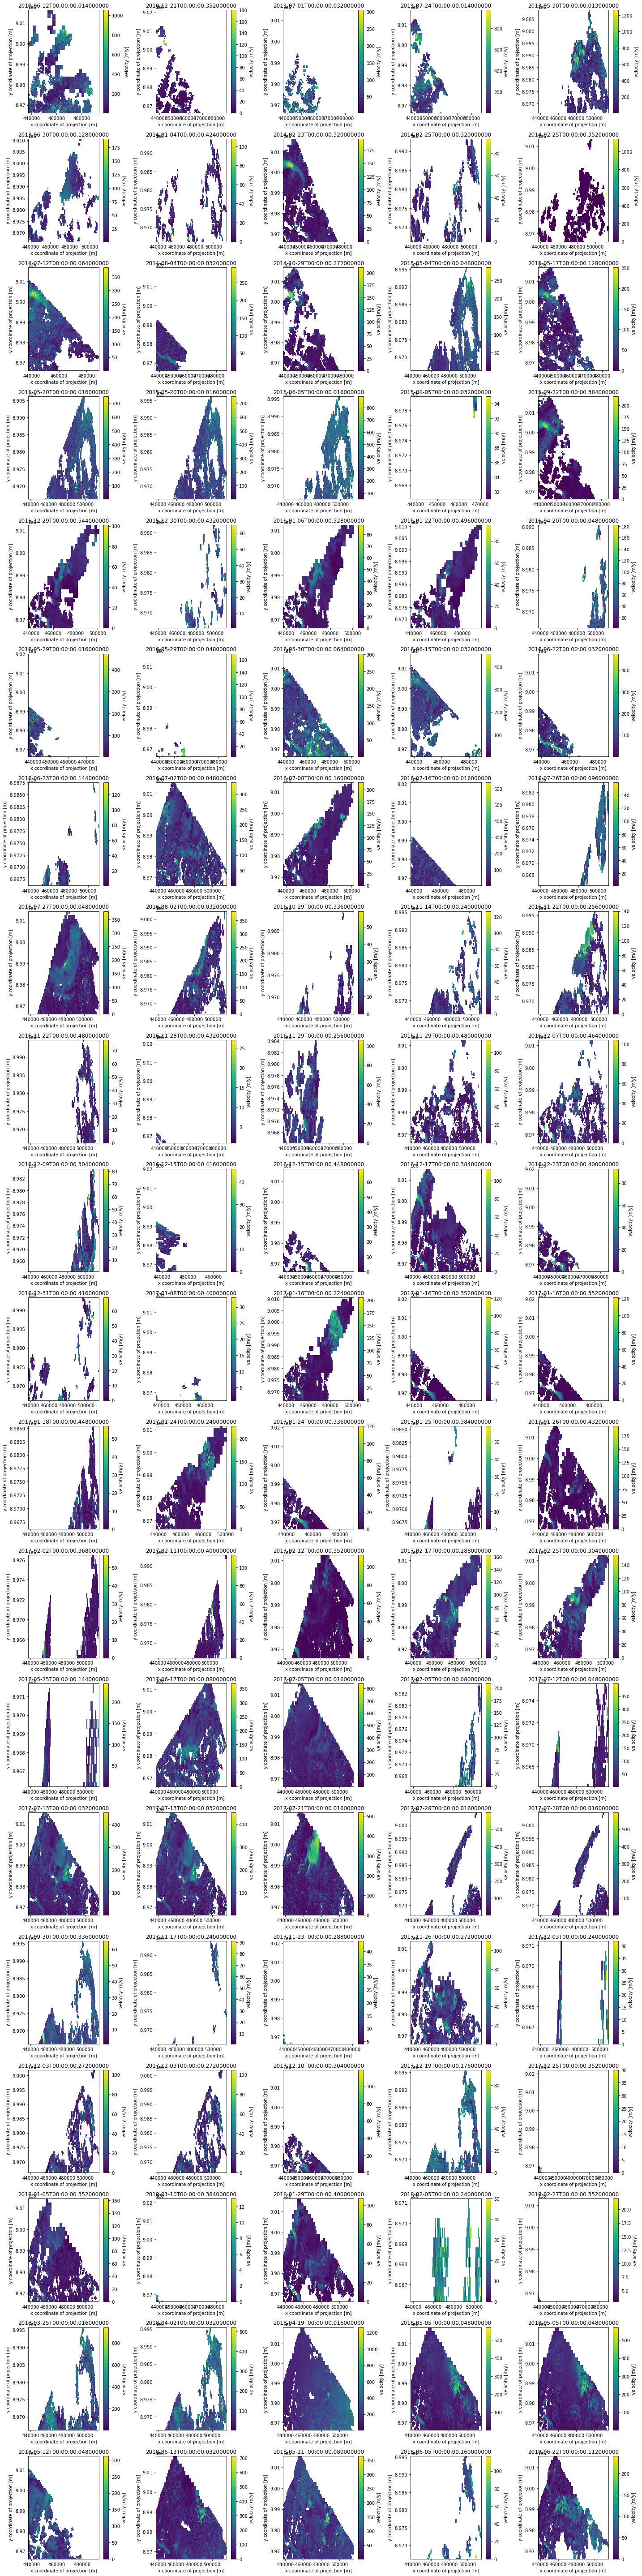

In [6]:
cube.plot_layers()

### Download granules locally and build the cube accessing local files

#### Invoke the following cell ONLY if granules were not downloaded yet (downloads to default "data" directory)

In [7]:
# from itslive import itslive_ui
# ui = itslive_ui('north')
# files = ui.download_velocity_pairs(found_urls, start=0, end=100)

In [10]:
local_cube = ITSCube(polygon, projection)
found_urls, skipped_projs = local_cube.create_from_local()

Processing local granules: 0it [00:00, ?it/s]
Combining layers by date: 0it [00:00, ?it/s]

Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]
Found:  0


AttributeError: 'dict' object has no attribute 'attrs'

#### Read local files in parallel using Dask

In [39]:
parallel_cube = ITSCube(polygon, projection)
found_urls, skipped_projs = parallel_cube.create_from_local_parallel()

Longitude/latitude coords for polygon: [-18.853615384172965, 81.6356820300733, -12.689367193215306, 81.64763330453586, -12.91144647782456, 80.75241792169454, -18.483852839771348, 80.74163892715585, -18.853615384172965, 81.6356820300733]
Skipped granules:
      empty data: 0 (0.0%)
      wrong proj: 0 (0.0%)


In [41]:
# parallel_cube.layers.attrs
# len(parallel_cube.layers.attrs['url'])

### Examine random cube layer

In [48]:
# Examine one of the layers
first_date = list(cube.velocities.keys())[0]
first_layer = cube.velocities[first_date][0]
first_date, first_layer
# first_layer.x.values

(numpy.datetime64('2015-08-05T00:00:00.032000000'),
 <xarray.DataArray 'v' (y: 57, x: 137)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * x         (x) float64 4.376e+05 4.379e+05 4.381e+05 ... 4.7e+05 4.703e+05
   * y         (y) float64 8.98e+06 8.979e+06 8.979e+06 ... 8.967e+06 8.966e+06
     mid_date  datetime64[ns] 2015-08-05T00:00:00.032000
 Attributes:
     units:                m/y
     standard_name:        velocity
     map_scale_corrected:  [0]
     best_practice:        velocities should always be merged/averaged using c...
     grid_mapping:         UTM_Projection
     url:                  http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/...)

In [49]:
first_layer.attrs

{'units': 'm/y',
 'standard_name': 'velocity',
 'map_scale_corrected': array([0], dtype=int8),
 'best_practice': 'velocities should always be merged/averaged using component velocities to prevent high velocity magnitude bias',
 'grid_mapping': 'UTM_Projection',
 'url': 'http://its-live-data.jpl.nasa.gov.s3.amazonaws.com/velocity_image_pair/landsat/v00.0/32628/LC08_L1TP_011002_20150821_20170405_01_T1_X_LC08_L1TP_011002_20150720_20170406_01_T1_G0240V01_P038.nc'}

In [50]:
first_layer.x

<xarray.DataArray 'x' (x: 137)>
array([437632.5, 437872.5, 438112.5, 438352.5, 438592.5, 438832.5, 439072.5,
       439312.5, 439552.5, 439792.5, 440032.5, 440272.5, 440512.5, 440752.5,
       440992.5, 441232.5, 441472.5, 441712.5, 441952.5, 442192.5, 442432.5,
       442672.5, 442912.5, 443152.5, 443392.5, 443632.5, 443872.5, 444112.5,
       444352.5, 444592.5, 444832.5, 445072.5, 445312.5, 445552.5, 445792.5,
       446032.5, 446272.5, 446512.5, 446752.5, 446992.5, 447232.5, 447472.5,
       447712.5, 447952.5, 448192.5, 448432.5, 448672.5, 448912.5, 449152.5,
       449392.5, 449632.5, 449872.5, 450112.5, 450352.5, 450592.5, 450832.5,
       451072.5, 451312.5, 451552.5, 451792.5, 452032.5, 452272.5, 452512.5,
       452752.5, 452992.5, 453232.5, 453472.5, 453712.5, 453952.5, 454192.5,
       454432.5, 454672.5, 454912.5, 455152.5, 455392.5, 455632.5, 455872.5,
       456112.5, 456352.5, 456592.5, 456832.5, 457072.5, 457312.5, 457552.5,
       457792.5, 458032.5, 458272.5, 458512.5, 458752.5, 458992.5, 459232.5,
       459472.5, 459712.5, 459952.5, 460192.5, 460432.5, 460672.5, 460912.5,
       461152.5, 461392.5, 461632.5, 461872.5, 462112.5, 462352.5, 462592.5,
       462832.5, 463072.5, 463312.5, 463552.5, 463792.5, 464032.5, 464272.5,
       464512.5, 464752.5, 464992.5, 465232.5, 465472.5, 465712.5, 465952.5,
       466192.5, 466432.5, 466672.5, 466912.5, 467152.5, 467392.5, 467632.5,
       467872.5, 468112.5, 468352.5, 468592.5, 468832.5, 469072.5, 469312.5,
       469552.5, 469792.5, 470032.5, 470272.5])
Coordinates:
  * x         (x) float64 4.376e+05 4.379e+05 4.381e+05 ... 4.7e+05 4.703e+05
    mid_date  datetime64[ns] 2015-08-05T00:00:00.032000
Attributes:
    units:          m
    standard_name:  projection_x_coordinate
    long_name:      x coordinate of projection

### Display cube layers

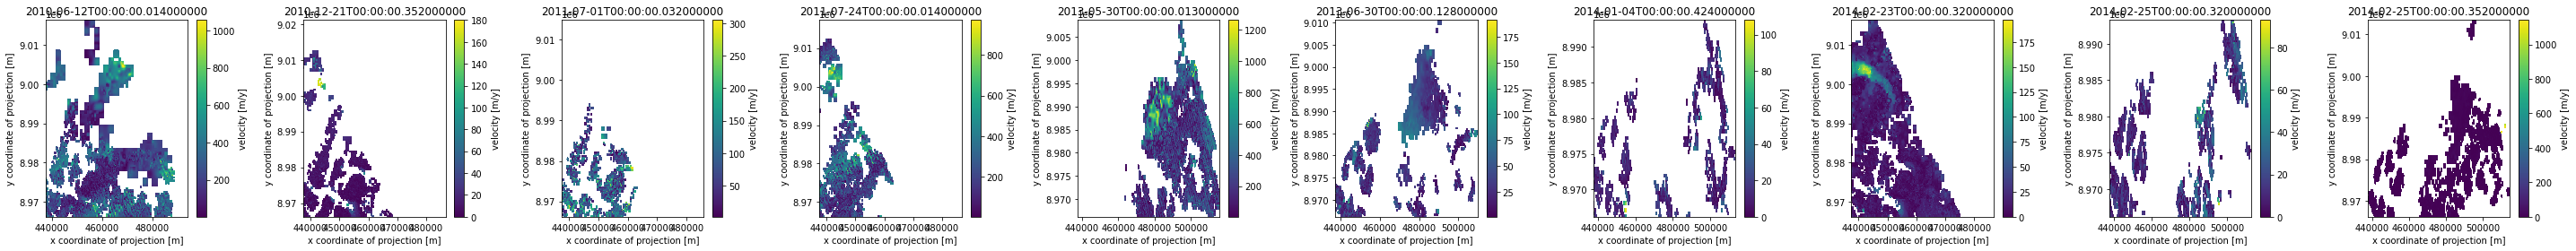

In [57]:
# cube.plot_layers()
cube.plot_num_layers(10)

In [59]:
# Does not work now that there are multiple "mid_date" coordinates with the same value:
cube.plot()

Not supported anymore since xarray can't use non-unique faceted values (mid_date) for plotting 
